In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

## Annotation

In [2]:
import requests

def get_cell_hierarchy(cell_name):
    search_url = "https://www.ebi.ac.uk/ols/api/search"
    params = {
        'q': cell_name,
        'ontology': 'cl',
        'exact': True,
        'fieldList': 'iri,label'
    }
    
    try:
        # Step 1: Get the IRI of the queried cell
        response = requests.get(search_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if data['response']['numFound'] == 0:
            print(f"No results found for '{cell_name}' in the Cell Ontology.")
            return None
        
        term_iri = data['response']['docs'][0]['iri']
        term_name = data['response']['docs'][0]['label']
        hierarchy_list = []  # List to store (cell_name, parent_name)
        hierarchy_list.append(('start', term_name))

        # Step 2: Recursive function to get parent hierarchy
        def get_parents(iri):
            term_url = f"https://www.ebi.ac.uk/ols/api/ontologies/cl/terms?iri={iri}"
            term_response = requests.get(term_url)
            term_response.raise_for_status()
            term_data = term_response.json()

            # Extract cell name (label)
            label = term_data["_embedded"]["terms"][0].get("label", "Unknown")

            # Stop if we reach "cell"
            if label.lower() == "cell":
                return

            # Fetch parent terms
            parent_url = term_data["_embedded"]["terms"][0]["_links"].get("parents", {}).get("href", None)
            if parent_url:
                parent_response = requests.get(parent_url)
                if parent_response.status_code == 200:
                    parent_data = parent_response.json()
                    for parent in parent_data["_embedded"]["terms"]:
                        parent_label = parent.get("label", "Unknown")
                        hierarchy_list.append((label, parent_label))  # Store cell-parent pair
                        
                        # Stop if we reach "cell"
                        if parent_label.lower() == "cell":
                            return
                        
                        get_parents(parent["iri"])  # Recursively get higher-level parents
        
        # Step 3: Build parent hierarchy
        get_parents(term_iri)
        
        return hierarchy_list  # Return list of tuples

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

# Example usage
cell_parent_list = get_cell_hierarchy("Stratified epithelial cell")
print(cell_parent_list)


[('stratified epithelial cell', 'epithelial cell'), ('epithelial cell', 'eukaryotic cell'), ('eukaryotic cell', 'cell'), ('stratified epithelial cell', 'BFO_0000002')]


In [21]:
res_HCL = pd.read_csv('/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/HCL/combined_results.csv')
res_MCA = pd.read_csv('/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/MCA/combined_results.csv')

In [43]:
import re
import numpy as np
import pandas as pd

def extract_cell_type(answer):
    if pd.isna(answer):
        return np.nan
    answer = answer.strip()
    cell_type = None

    # 1) Look for a double newline pattern: text between "\n\n" and a trailing confidence score.
    newline_match = re.search(r'\n\n\s*([^(\n]+?)\s*\(\d+\.?\d*\)', answer)
    if newline_match:
        cell_type = newline_match.group(1).strip()
    else:
        # 2a) Look for an ANSWER(...) pattern (with parentheses)
        answer_parenthesis_match = re.search(r'ANSWER[:\s]*\(\s*([^(]+?)\s*\)(?:\s*\(\d+\.?\d*\))?', answer, re.IGNORECASE)
        if answer_parenthesis_match:
            cell_type = answer_parenthesis_match.group(1).strip()
        else:
            # 2b) Look for ANSWER: followed by text then a confidence score in parentheses
            answer_colon_match = re.search(r'ANSWER[:\s]+([^(\n]+?)\s*\(\d+\.?\d*\)', answer, re.IGNORECASE)
            if answer_colon_match:
                cell_type = answer_colon_match.group(1).strip()
            else:
                # 2c) Look for ANSWER: followed by text (without a trailing confidence score)
                answer_simple_match = re.search(r'ANSWER[:\s]+(.+)', answer, re.IGNORECASE)
                if answer_simple_match:
                    cell_type = answer_simple_match.group(1).strip()
                else:
                    # 2d) Look for text before a trailing confidence score (if any)
                    number_match = re.search(r'^(.*?)\s*\(\d+\.?\d*\)', answer)
                    if number_match:
                        cell_type = number_match.group(1).strip()
                    else:
                        # Fallback: use the whole answer
                        cell_type = answer

    # 3) Clean up the result:
    # 1. Remove "ANSWER" and any surrounding symbols/whitespace (case-insensitive)
    cell_type = re.sub(r'(?i)^[\W\s]*ANSWER[\W\s]*', '', cell_type)  # ✅ Removes **ANSWER**: 
    # 2. Remove parentheses and their content
    cell_type = re.sub(r'\([^)]*\)', '', cell_type)                  # ✅ Removes (with extra info)
    # Remove stray symbols like brackets or quotes.
    cell_type = re.sub(r'[\[\]\'"]', '', cell_type).strip()
    return cell_type

# Apply the function to your DataFrame column 'answer'
res_HCL['final_res'] = res_HCL['answer'].apply(extract_cell_type)
res_MCA['final_res'] = res_MCA['answer'].apply(extract_cell_type)

In [ ]:
res_MCA = res_MCA[res_MCA['answer'].notna()]
res_MCA['final_res_ontology'] = res_MCA['final_res'].apply(get_cell_hierarchy)
res_MCA['truth_ontology'] = res_MCA['id'].apply(get_cell_hierarchy)
res_HCL = res_HCL[res_HCL['answer'].notna()]
res_HCL['final_res_ontology'] = res_HCL['final_res'].apply(get_cell_hierarchy)
res_HCL['truth_ontology'] = res_HCL['id'].apply(get_cell_hierarchy)
res_MCA.to_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/MCA/combined_results_evaluation.csv")
res_HCL.to_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/HCL/combined_results_evaluation.csv")

In [7]:
def extract_chain(pairs):
    if not pairs:
        return []
    # Initialize with the first pair
    chain = list(pairs[0])
    current = chain[-1]
    
    while current != 'cell':
        found = False
        for pair in pairs:
            if pair[0] == current:
                chain.append(pair[1])
                current = pair[1]
                found = True
                break
        if not found:
            break  # In case there's no further pair, though the problem implies there should be
    return chain

In [5]:
res_MCA = pd.read_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/MCA/combined_results_evaluation.csv")
res_HCL = pd.read_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/HCL/combined_results_evaluation.csv")
res_HCL['source'] = 'Human'
res_MCA['source'] = 'Mouse'
res = pd.concat([res_HCL, res_MCA], axis=0, ignore_index=True)
res = res[~res[['final_res_ontology', 'truth_ontology']].isnull().any(axis=1)]

import ast
res['final_res_ontology'] = res['final_res_ontology'].apply(ast.literal_eval)
res['truth_ontology'] = res['truth_ontology'].apply(ast.literal_eval)

In [8]:
res['final_res_chain'] = res['final_res_ontology'].apply(extract_chain)
res['truth_chain'] = res['truth_ontology'].apply(extract_chain)

In [10]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from scipy.spatial.distance import cosine

def calculate_percentage_overlap(chain1, chain2):
    """Calculate the percentage of overlap between two hierarchical chains"""
    set1 = set(chain1)
    set2 = set(chain2)
    overlap = set1.intersection(set2)
    overlap_percentage = len(overlap) / len(set1) * 100  # Or use len(set2) as denominator
    return overlap_percentage

# Load the SapBERT model and tokenizer
model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # Get the embeddings from the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the mean of the last hidden state as the sentence embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings

def calculate_similarity(text1, text2):
    """Calculate semantic similarity between two text descriptions"""
    embedding1 = get_embeddings(text1)
    embedding2 = get_embeddings(text2)
    similarity = 1 - cosine(embedding1, embedding2)  # Cosine similarity
    return similarity

def calculate_final_score(final_res_chain, truth_chain, w1=0.5, w2=0.5):
    """Calculate final score, semantic similarity, and overlap percentage"""
    # 1. Semantic Similarity using embeddings
    predicted_type = final_res_chain[0]
    true_type = truth_chain[0]
    semantic_similarity = calculate_similarity(predicted_type, true_type)
    
    # 2. Percentage Overlap in hierarchical ontology
    overlap_percentage = calculate_percentage_overlap(final_res_chain, truth_chain)
    normalized_overlap_percentage = overlap_percentage / 100  # Normalize to 0-1 scale
    
    # 3. Final Score (weighted sum)
    final_score = w1 * semantic_similarity + w2 * normalized_overlap_percentage
    
    return final_score, semantic_similarity, normalized_overlap_percentage

def apply_similarity_function(df, w1=0.5, w2=0.5):
    """Apply the calculate_final_score function to the dataframe and add new columns"""
    # Apply function to each row in the dataframe
    df[['final_score', 'semantic_similarity', 'normalized_overlap_percentage']] = df.apply(
        lambda row: pd.Series(calculate_final_score(row['final_res_chain'], row['truth_chain'], w1, w2)),
        axis=1
    )
    return df

# Apply function to compute final_score, semantic_similarity, and normalized_overlap_percentage
res = apply_similarity_function(res, w1=0.5, w2=0.5)

# Assign group
res['group'] = res['truth_chain'].apply(lambda x: x[-2] if len(x) >= 2 else x[-1])
print(res.head())

/opt/anaconda3/envs/llms/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Unnamed: 0                                           question  \
0           0  \n            You are given a list of differen...   
1           1  \n            You are given a list of differen...   
3           3  \n            You are given a list of differen...   
5           5  \n            You are given a list of differen...   
6           6  \n            You are given a list of differen...   

                                   answer  \
0                  Epithelial Cell (0.85)   
1                        Epithelial cells   
3                            Paneth cells   
5  ANSWER(Macrophages/immune cells)(0.95)   
6                     ANSWER:Colon(0.800)   

                                           reasoning  confidence  time_taken  \
0                                                NaN        0.85     194.411   
1  The list contains genes such as 'KRT7', 'KRT19...        0.95       3.158   
3  The list of genes provided includes several ma...        0.75       5.671   


In [11]:
res['group'] = res['truth_chain'].apply(lambda x: x[-2] if len(x) >= 2 else x[-1])
res.head()

,Unnamed: 0,question,answer,reasoning,confidence,time_taken,error,model,id,final_res,final_res_ontology,truth_ontology,source,final_res_chain,truth_chain,final_score,semantic_similarity,normalized_overlap_percentage,group
0,0,\n You are given a list of differen...,Epithelial Cell (0.85),NaN,0.85,194.411,NaN,deepseek-chat,Stratified epithelial cell,Epithelial Cell,"[(epithelial cell, eukaryotic cell), (eukaryot...","[(stratified epithelial cell, epithelial cell)...",Human,"[epithelial cell, eukaryotic cell, cell]","[stratified epithelial cell, epithelial cell, ...",0.911796,0.823592,1.000000,eukaryotic cell
1,1,\n You are given a list of differen...,Epithelial cells,"The list contains genes such as 'KRT7', 'KRT19...",0.95,3.158,NaN,gpt-4o,Stratified epithelial cell,Epithelial cells,"[(epithelial cell of thymus, endo-epithelial c...","[(stratified epithelial cell, epithelial cell)...",Human,"[epithelial cell of thymus, endo-epithelial ce...","[stratified epithelial cell, epithelial cell, ...",0.616874,0.633747,0.600000,eukaryotic cell
3,3,\n You are given a list of differen...,Paneth cells,The list of genes provided includes several ma...,0.75,5.671,NaN,Qwen/Qwen2.5-72B-Instruct,Stratified epithelial cell,Paneth cells,"[(duodenum secretory cell, small intestine sec...","[(stratified epithelial cell, epithelial cell)...",Human,"[duodenum secretory cell, small intestine secr...","[stratified epithelial cell, epithelial cell, ...",0.356591,0.513183,0.200000,eukaryotic cell
5,5,\n You are given a list of differen...,ANSWER(Macrophages/immune cells)(0.95),NaN,0.95,63.781,NaN,deepseek-ai/DeepSeek-R1-Distill-Qwen-7B,Stratified epithelial cell,Macrophages/immune cells,"[(lung macrophage, macrophage), (macrophage, m...","[(stratified epithelial cell, epithelial cell)...",Human,"[lung macrophage, macrophage, myeloid leukocyt...","[stratified epithelial cell, epithelial cell, ...",0.282092,0.397518,0.166667,eukaryotic cell
6,6,\n You are given a list of differen...,ANSWER:Colon(0.800),NaN,0.80,13.772,NaN,deepseek-ai/DeepSeek-R1-Distill-Llama-8B,Stratified epithelial cell,Colon,"[(colon, subdivision of digestive tract), (sub...","[(stratified epithelial cell, epithelial cell)...",Human,"[colon, subdivision of digestive tract, subdiv...","[stratified epithelial cell, epithelial cell, ...",0.174577,0.349153,0.000000,eukaryotic cell


In [4]:
res = pd.read_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/combined_results_evaluation.csv")

In [5]:
res['model'] = res['model'].replace({
    'Qwen/Qwen2.5-72B-Instruct': 'Qwen2.5-72B',  
    'deepseek-ai/DeepSeek-R1-Distill-Llama-8B': 'Distill-Llama-8B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': 'Distill-Qwen-7B',  
    'deepseek-chat': 'DeepSeek-V3',
    'deepseek-reasoner': 'DeepSeek-R1',  
    'meta-llama/Meta-Llama-3.1-405B-Instruct': 'Llama-3.1-405B',
    'gpt-4o': 'GPT-4o'
})

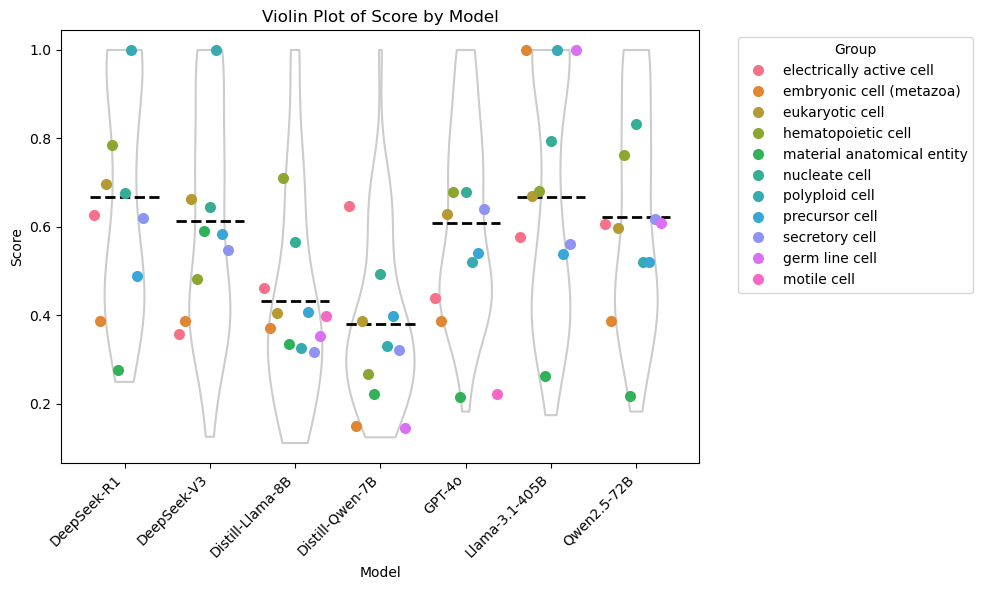

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a consistent order for models (alphabetical order here)
model_order = sorted(res['model'].unique())

# Compute the mean final score for each model and group
model_group_means = res.groupby(['model', 'group'])['final_score'].mean().reset_index()

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='model', y='final_score', data=res, inner=None, color=".8", order=model_order, fill=False, cut=0)

# Overlay the mean values as dots for each group within each model
sns.stripplot(x='model', y='final_score', data=model_group_means, hue='group',
              dodge=True, jitter=True, size=8, order=model_order)

# Compute the overall mean accuracy for each model and draw horizontal dashed lines (optional)
model_means = res.groupby('model')['final_score'].mean().reset_index()
for i, model in enumerate(model_order):
    mean_val = model_means.loc[model_means['model'] == model, 'final_score'].values[0]
    plt.hlines(mean_val, i - 0.4, i + 0.4, colors='black', linestyles='--', lw=2)

plt.title('Violin Plot of Score by Model')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [6]:
res.head()

,Unnamed: 0.1,Unnamed: 0,question,answer,reasoning,confidence,time_taken,error,model,id,final_res,final_res_ontology,truth_ontology,source,final_res_chain,truth_chain,final_score,semantic_similarity,normalized_overlap_percentage,group
0,0,0,\n You are given a list of differen...,Epithelial Cell (0.85),NaN,0.85,194.411,NaN,DeepSeek-V3,Stratified epithelial cell,Epithelial Cell,"[('epithelial cell', 'eukaryotic cell'), ('euk...","[('stratified epithelial cell', 'epithelial ce...",Human,"['epithelial cell', 'eukaryotic cell', 'cell']","['stratified epithelial cell', 'epithelial cel...",0.911796,0.823592,1.000000,eukaryotic cell
1,1,1,\n You are given a list of differen...,Epithelial cells,"The list contains genes such as 'KRT7', 'KRT19...",0.95,3.158,NaN,GPT-4o,Stratified epithelial cell,Epithelial cells,"[('epithelial cell of thymus', 'endo-epithelia...","[('stratified epithelial cell', 'epithelial ce...",Human,"['epithelial cell of thymus', 'endo-epithelial...","['stratified epithelial cell', 'epithelial cel...",0.616874,0.633747,0.600000,eukaryotic cell
2,3,3,\n You are given a list of differen...,Paneth cells,The list of genes provided includes several ma...,0.75,5.671,NaN,Qwen2.5-72B,Stratified epithelial cell,Paneth cells,"[('duodenum secretory cell', 'small intestine ...","[('stratified epithelial cell', 'epithelial ce...",Human,"['duodenum secretory cell', 'small intestine s...","['stratified epithelial cell', 'epithelial cel...",0.356591,0.513183,0.200000,eukaryotic cell
3,5,5,\n You are given a list of differen...,ANSWER(Macrophages/immune cells)(0.95),NaN,0.95,63.781,NaN,Distill-Qwen-7B,Stratified epithelial cell,Macrophages/immune cells,"[('lung macrophage', 'macrophage'), ('macropha...","[('stratified epithelial cell', 'epithelial ce...",Human,"['lung macrophage', 'macrophage', 'myeloid leu...","['stratified epithelial cell', 'epithelial cel...",0.282092,0.397518,0.166667,eukaryotic cell
4,6,6,\n You are given a list of differen...,ANSWER:Colon(0.800),NaN,0.80,13.772,NaN,Distill-Llama-8B,Stratified epithelial cell,Colon,"[('colon', 'subdivision of digestive tract'), ...","[('stratified epithelial cell', 'epithelial ce...",Human,"['colon', 'subdivision of digestive tract', 's...","['stratified epithelial cell', 'epithelial cel...",0.174577,0.349153,0.000000,eukaryotic cell


/var/folders/mv/5359mrfx7yq8dl6fs3p4gy000000gn/T/ipykernel_68905/1605814836.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_avg = res.groupby('model').apply(compute_metrics)


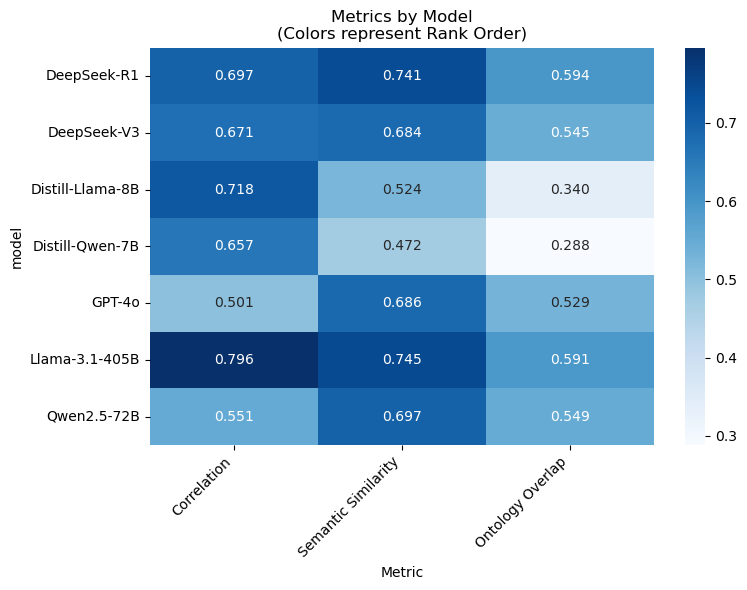

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Compute Metrics per Model ---
def compute_metrics(g):
    corr = g['semantic_similarity'].corr(g['normalized_overlap_percentage'])
    avg_semantic_similarity = g['semantic_similarity'].mean()
    avg_normalized_overlap_percentage = g['normalized_overlap_percentage'].mean()
    return pd.Series({
        'semantic_ontology_corr': corr,
        'avg_semantic_similarity': avg_semantic_similarity,
        'avg_normalized_ontology_overlap': avg_normalized_overlap_percentage
    })

df_avg = res.groupby('model').apply(compute_metrics)
df_avg = df_avg.sort_index()  # sort by model name (or any other ordering)

# --- Rename Columns ---
rename_dict = {
    'semantic_ontology_corr': 'Correlation',
    'avg_semantic_similarity': 'Semantic Similarity',
    'avg_normalized_ontology_overlap': 'Ontology Overlap'
}
df_avg.rename(columns=rename_dict, inplace=True)

# --- Create a Ranked DataFrame ---
df_ranked = df_avg.rank(ascending=True)

# --- Plot Heatmap ---
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    df_avg, 
    annot=df_avg,         # Annotate with actual metric values
    fmt=".3f", 
    cmap="Blues"
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel("Metric")
plt.title("Metrics by Model\n(Colors represent Rank Order)")

plt.tight_layout()
plt.show()



## Reasoning content analysis

In [5]:
import pandas as pd
import string

df = pd.read_excel("/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/41586_2020_2157_MOESM3_ESM.xlsx", header=None)
gene_names = df.iloc[2:, 1::4].head(20).values.flatten().tolist()

print(len(gene_names))

def extract_marker_name(text, gene_names):
    # Extract gene names from text using given list of gene names
    tokens = text.split()
    # Create a translation table that maps each punctuation symbol to None
    translator = str.maketrans('', '', string.punctuation)
    # Apply the translation to each element in the list
    clean_data = [item.translate(translator) for item in tokens]
    genes = [gene for gene in clean_data if gene in gene_names]
    ## convert to set to remove duplicates
    genes = set(genes)
    return genes

# Example usage
text = "The expression of BEX3, CTSB, and JCHAIN was analyzed in the study."
extracted_genes = extract_marker_name(text, gene_names)
print(extracted_genes)

2040
{'BEX3', 'CTSB', 'JCHAIN'}


/opt/anaconda3/envs/llms/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
import pandas as pd
from io import BytesIO
import gzip

# Download PanglaoDB marker gene compendium (human and mouse, March 2020)
marker_path = "/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/PanglaoDB_markers_27_Mar_2020.tsv.gz"
with gzip.open(marker_path, 'rt') as f:
    panglao_df = pd.read_csv(f, sep='\t')

# Construct dictionary: cell_type -> set of marker genes
panglao_markers = {}
for _, row in panglao_df.iterrows():
    cell = row['cell type']
    gene = row['official gene symbol']
    panglao_markers.setdefault(cell, set()).add(gene)
    
# Example: list first 5 markers for a given cell type
cell_type = "T cells"
print(cell_type, "markers (PanglaoDB):", list(panglao_markers[cell_type])[:5])

T cells markers (PanglaoDB): ['H2-T3', 'CCL6', 'CD52', 'MYO1G', 'GIMAP2']


In [8]:
## extract key from panglao_markers
panglao_markers = {key.lower(): value for key, value in panglao_markers.items()}

In [9]:
import re

def generate_cell_type_pattern(cell_type):
    """
    Generate a regex pattern from a cell type name.
    If the name contains 'cell' or 'cells', the regex will allow for matching the main part
    (i.e. the original name with 'cell' or 'cells' removed) with or without the word 'cell' (or 'cells') appended.
    Otherwise, the pattern matches exactly the original cell type name.
    """
    cell_type = cell_type.strip().lower()
    words = cell_type.split()
    
    # Remove all occurrences of 'cell' or 'cells' from the list of words.
    words_without_cells = [word for word in words if word not in ("cell", "cells")]
    
    # If any word was removed, then we treat the main_part as the name without 'cell(s)'
    if len(words_without_cells) < len(words):
        # If removing 'cell(s)' leaves nothing, then default to 'cell'
        main_part = " ".join(words_without_cells) if words_without_cells else "cell"
        # Pattern allows matching main_part with an optional 'cell' or 'cells'
        pattern = r'^' + re.escape(main_part) + r'(?:\s+cell(?:s)?)?$'
    else:
        # No 'cell' or 'cells' found; match exactly the original name.
        pattern = r'^' + re.escape(cell_type) + r'$'
    
    return re.compile(pattern, re.IGNORECASE)

def matches_cell_type(query, cell_type):
    """
    Returns True if the query matches the cell type name (considering optional 'cell' or 'cells').
    """
    pattern = generate_cell_type_pattern(cell_type)
    return bool(pattern.match(query.strip()))

def find_matching_keys(query, cell_dict):
    """
    Returns a list of keys from cell_dict that match the query.
    """
    return [key for key in cell_dict.keys() if matches_cell_type(query, key)]

# Example: list first 5 markers for a given cell type
cell_type = "t cell"
matched_key = find_matching_keys(cell_type, panglao_markers)
print(cell_type, "markers (PanglaoDB):", list(panglao_markers[matched_key[0]])[:5])

t cell markers (PanglaoDB): ['H2-T3', 'CCL6', 'CD52', 'MYO1G', 'GIMAP2']


In [ ]:
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# Download NLTK tokenizer models if not already available.
nltk.download('punkt')

def generate_cell_type_pattern(cell_type):
    """
    Generate a regex pattern from a cell type name.
    If the name contains 'cell' or 'cells', the regex will allow for matching the main part
    (i.e. the original name with 'cell' or 'cells' removed) with or without the word 'cell' (or 'cells') appended.
    Otherwise, the pattern matches exactly the original cell type name.
    """
    cell_type = cell_type.strip().lower()
    words = cell_type.split()
    
    # Remove all occurrences of 'cell' or 'cells' from the list of words.
    words_without_cells = [word for word in words if word not in ("cell", "cells")]
    
    # If any word was removed, then we treat the main_part as the name without 'cell(s)'
    if len(words_without_cells) < len(words):
        # If removing 'cell(s)' leaves nothing, then default to 'cell'
        main_part = " ".join(words_without_cells) if words_without_cells else "cell"
        # Pattern allows matching main_part with an optional 'cell' or 'cells'
        pattern = r'^' + re.escape(main_part) + r'(?:\s+cell(?:s)?)?$'
    else:
        # No 'cell' or 'cells' found; match exactly the original name.
        pattern = r'^' + re.escape(cell_type) + r'$'
    
    return re.compile(pattern, re.IGNORECASE)

def matches_cell_type(query, cell_type):
    """
    Returns True if the query matches the cell type name (considering optional 'cell' or 'cells').
    """
    pattern = generate_cell_type_pattern(cell_type)
    return bool(pattern.match(query.strip()))

def find_matching_keys(query, cell_dict):
    """
    Returns a list of keys from cell_dict that match the query.
    """
    return [key for key in cell_dict.keys() if matches_cell_type(query, key)]

def compute_marker_metrics(extracted_markers, reference_markers):
    """
    Computes overlap, agreement, precision, recall, F1-score, and knowledge overlap score.
    
    Parameters:
        extracted_markers (set): Marker genes extracted from the LLM reasoning.
        reference_markers (set): The reference (ground truth) marker set for the cell type.
    
    Returns:
        dict: A dictionary containing overlap, agreement, precision, recall, F1, and knowledge_overlap.
    """
    overlap = extracted_markers.intersection(reference_markers)
    precision = len(overlap) / len(extracted_markers) if extracted_markers else 0.0
    recall = len(overlap) / len(reference_markers) if reference_markers else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    union = extracted_markers.union(reference_markers)
    jaccard = len(overlap) / len(union) if union else 0.0

    return {
        "overlap_count": len(overlap),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "knowledge_overlap": jaccard
    }


def process_llm_reasoning(df, known_genes, reference_marker_dict):
    """
    Processes a DataFrame containing LLM reasoning texts and computes marker extraction
    and reasoning metrics.
    
    Parameters:
        df (pd.DataFrame): DataFrame with at least columns 'reasoning', 'model', and 'final_res'.
        known_genes (set): Set of known marker gene symbols.
        reference_marker_dict (dict): Dictionary mapping predicted cell types to reference marker sets.
            
    Returns:
        pd.DataFrame: Original DataFrame augmented with computed metrics.
    """
    metrics_list = []
    
    for idx, row in df.iterrows():
        print(f"Processing row {idx+1} of {len(df)}...")
        reasoning = row["reasoning"]
        model = row["model"]
        
        # 1. Extract marker names from reasoning text.
        extracted_markers = extract_marker_name(reasoning, known_genes)
        predicted_cell_type = row['final_res'].lower()
        
        # Find matching keys from the reference marker dictionary.
        matched_keys = find_matching_keys(predicted_cell_type, reference_marker_dict)
        if matched_keys:
            ref_markers = reference_marker_dict.get(matched_keys[0], set())
        else:
            ref_markers = set()
            print(f"Warning: No matching cell type found for '{predicted_cell_type}' in reference markers.")
        
        # 2. Compute marker metrics
        marker_metrics = compute_marker_metrics(extracted_markers, ref_markers)
        
        # 4. Assemble the results into a dict
        metrics_dict = {
            "id": row["id"],
            "source": row['source'],
            "model": model,
            "extracted_marker_count": len(extracted_markers),
            "overlap_count": marker_metrics["overlap_count"],
            "precision": marker_metrics["precision"],
            "recall": marker_metrics["recall"],
            "f1": marker_metrics["f1"],
            "knowledge_overlap": marker_metrics["knowledge_overlap"]
        }
        metrics_list.append(metrics_dict)
        
    df_metrics = pd.DataFrame(metrics_list)
    return df_metrics

# Example usage (ensure that the following variables are defined appropriately):
# - res: your DataFrame with LLM reasoning outputs.
# - gene_names: a set containing known gene names.
# - panglao_markers: your reference marker dictionary.

if __name__ == "__main__":
    # Assuming 'res' is your DataFrame and it contains a 'reasoning' column.
    res = res[res['reasoning'].notna()]
    df_metrics = process_llm_reasoning(res, gene_names, panglao_markers)
    print("Computed Metrics:")
    print(df_metrics)


In [11]:
df_metrics.to_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/combined_results_evaluation_detailed_metrics.csv")

In [2]:
## read detailed metrics
df_metrics = pd.read_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/annotation/combined_results_evaluation_detailed_metrics.csv")
df_metrics['id'] = df_metrics['id'] + '_' + df_metrics['source']
print(df_metrics.head())

   Unnamed: 0                                id source           model  \
0           0  Stratified epithelial cell_Human  Human          GPT-4o   
1           1  Stratified epithelial cell_Human  Human     Qwen2.5-72B   
2           2                  Basal cell_Human  Human     DeepSeek-R1   
3           3                  Basal cell_Human  Human          GPT-4o   
4           4                  Basal cell_Human  Human  Llama-3.1-405B   

   extracted_marker_count  overlap_count  precision    recall        f1  \
0                       6              1   0.166667  0.006993  0.013423   
1                       6              0   0.000000  0.000000  0.000000   
2                      20              6   0.300000  0.125000  0.176471   
3                       6              4   0.666667  0.083333  0.148148   
4                       8              5   0.625000  0.104167  0.178571   

   knowledge_overlap  logical_coherence  
0           0.006757           0.336171  
1           0.000000

<Figure size 1000x600 with 0 Axes>

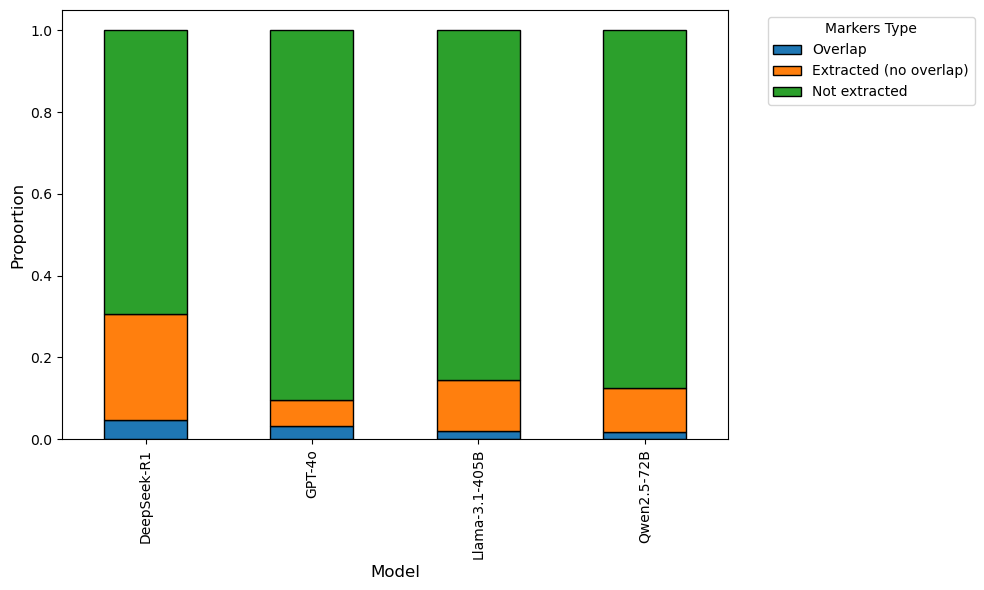

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

df_metrics['extracted_marker_prop'] = df_metrics['extracted_marker_count']/20
df_metrics['overlap_prop'] = df_metrics['overlap_count']/20

# --- 1. Group and compute average proportions ---
# Group by 'model' and compute the average extracted_marker_prop and overlap_prop.
df_grouped = df_metrics.groupby('model').agg({
    'extracted_marker_prop': 'mean',
    'overlap_prop': 'mean'
})

# --- 2. Compute additional proportions ---
# non_overlap: extracted but not overlapping.
df_grouped['non_overlap'] = df_grouped['extracted_marker_prop'] - df_grouped['overlap_prop']
# left_prop: not extracted (remainder to reach 1).
df_grouped['left_prop'] = 1 - df_grouped['extracted_marker_prop']
df_grouped = df_grouped.drop(columns=['extracted_marker_prop']).rename(columns={
    'overlap_prop': 'Overlap',
    'non_overlap': 'Extracted (no overlap)',
    'left_prop': 'Not extracted'
})

# --- 3. Plot stacked bar plot ---
plt.figure(figsize=(10, 6))
ax = df_grouped.plot(kind='bar', stacked=True, edgecolor='black', figsize=(10, 6))
plt.xlabel('Model', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Markers Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

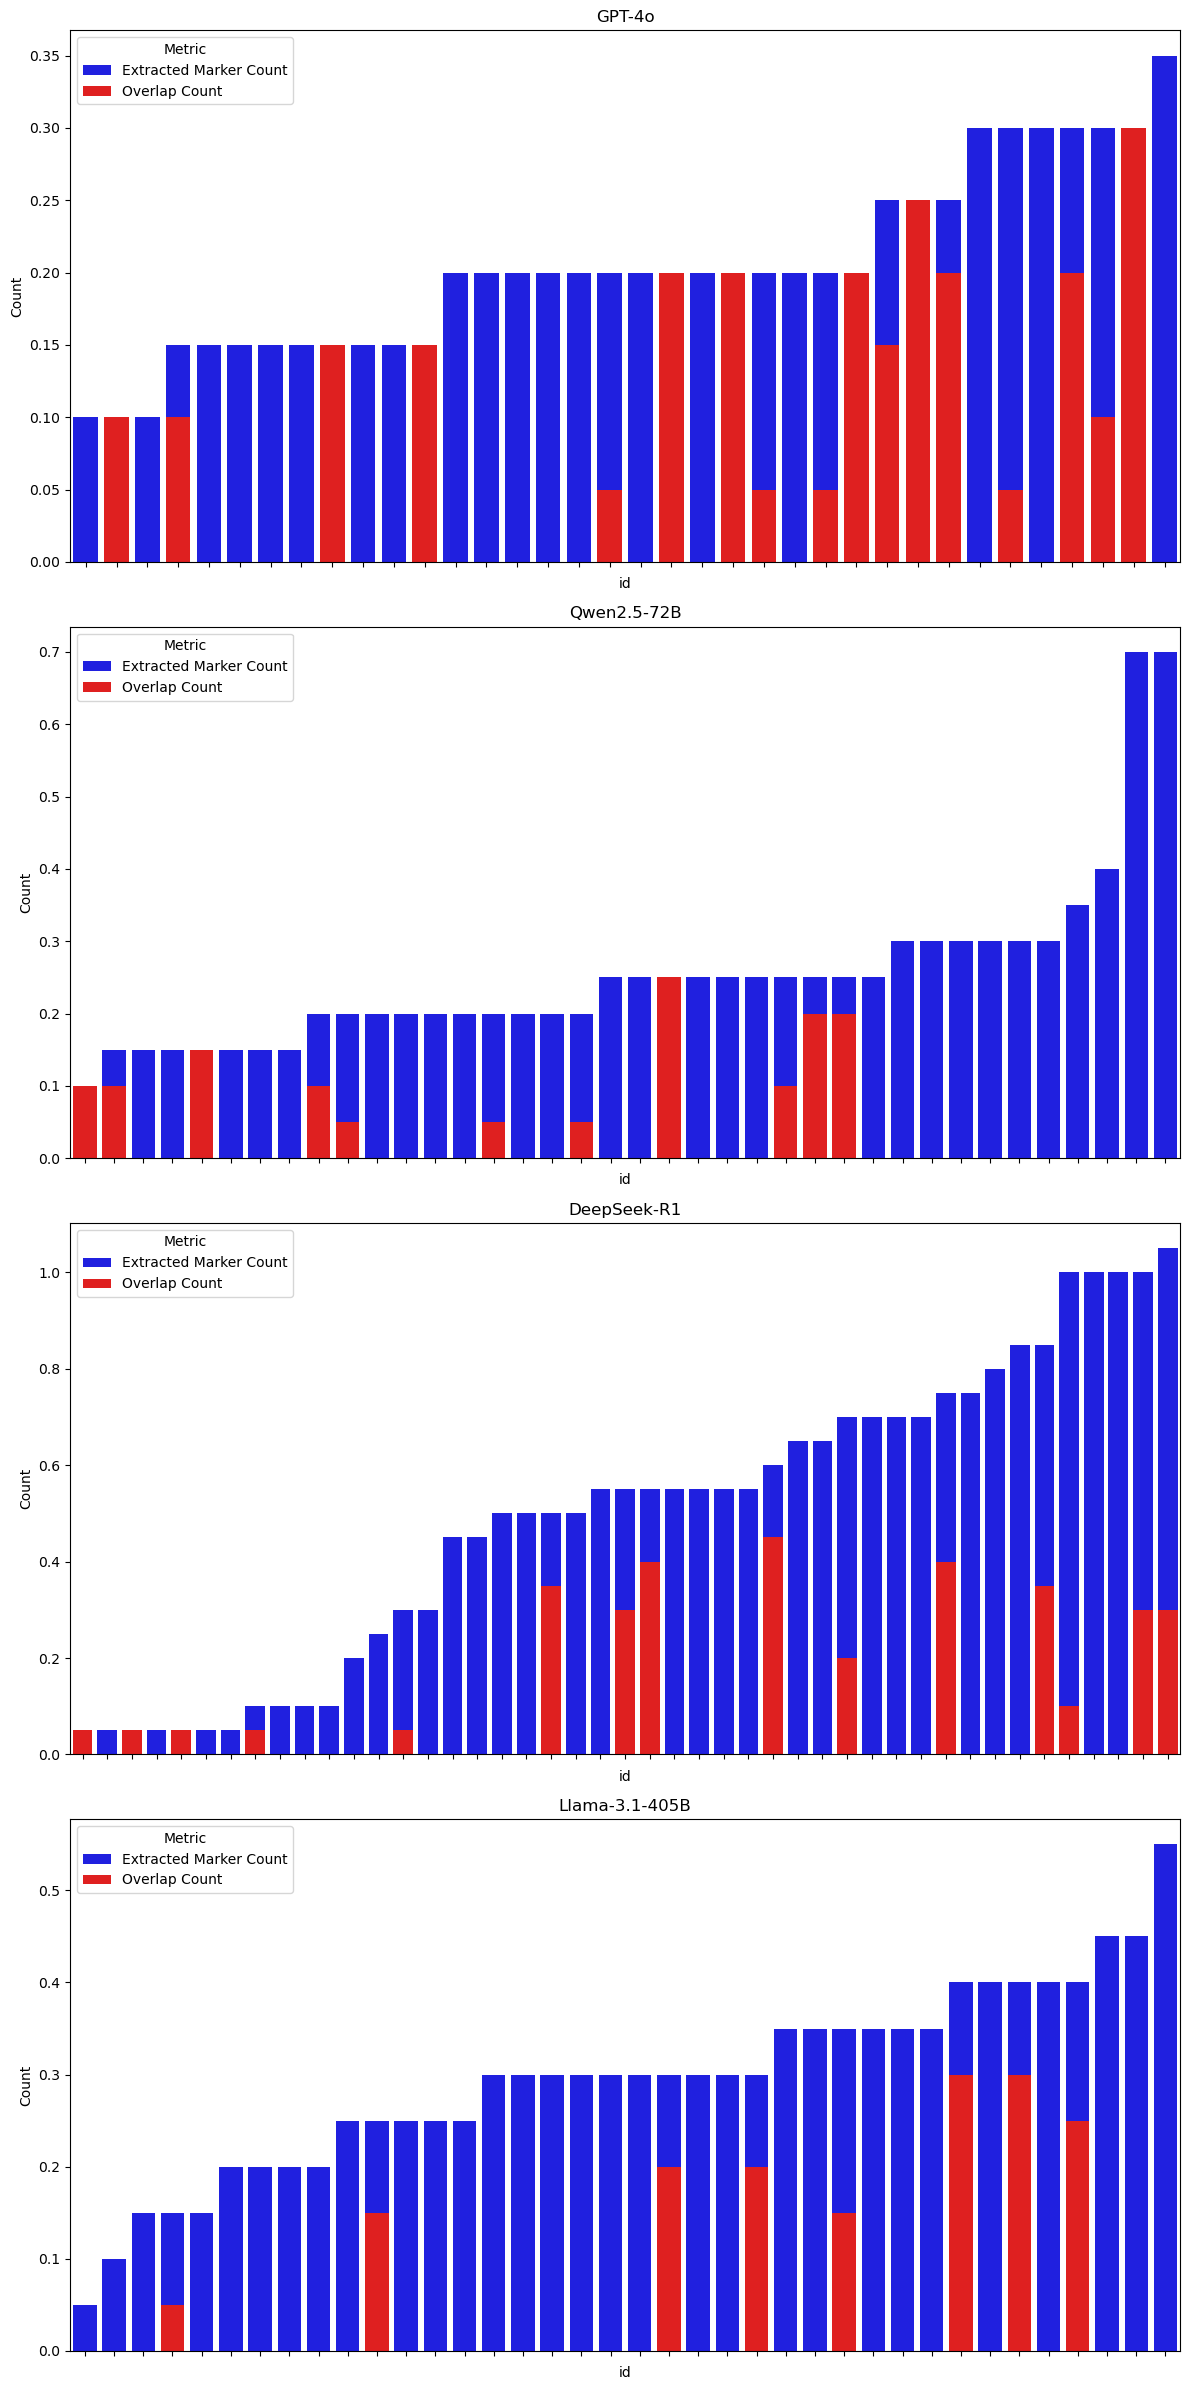

In [32]:
# Filter the data for rows with a positive extracted_marker_count.
plot_data = df_metrics[df_metrics['extracted_marker_prop'] > 0]

# Get the unique models.
models = plot_data['model'].unique()
n_models = len(models)

# Create one subplot per model.
fig, axes = plt.subplots(n_models, 1, figsize=(12, 6 * n_models), squeeze=False)
axes = axes.flatten()

for ax, model in zip(axes, models):
    # Filter and sort the data for the current model.
    model_data = plot_data[plot_data['model'] == model].copy()
    model_data = model_data.sort_values(by='extracted_marker_prop')
    
    # Plot extracted_marker_count (blue bars) with a label.
    sns.barplot(x=model_data["id"], y=model_data["extracted_marker_prop"],
                color='b', ax=ax, label='Extracted Marker Count')
    
    # Overlay overlap_count (red bars) with a label.
    sns.barplot(x=model_data["id"], y=model_data["overlap_prop"],
                color='r', ax=ax, label='Overlap Count')
    
    ax.set_ylabel("Count")
    ax.set_title(model)
    
    # remove labels in x-axis
    ax.set_xticklabels([])
    
    # Add a legend to the subplot.
    ax.legend(title="Metric", loc='upper left')

plt.tight_layout()
plt.savefig("/Users/linxy29/Documents/Files/other collaboration/benchmark/supplementary figure/Supplementary Figure t4 extracted marker.pdf")
plt.show()


## Reasoning

In [16]:
import pandas as pd
import textstat
import nltk
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# Download NLTK's punkt tokenizer if not already downloaded
nltk.download('punkt_tab')

# ----------------------------
# 1. Readability Analysis
# ----------------------------
def readability_analysis(text):
    """
    Compute readability metrics for the given text and return them as a dictionary.
    """
    metrics = {
        "flesch_reading_ease": textstat.flesch_reading_ease(text),
        "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
        "smog_index": textstat.smog_index(text)
    }
    return metrics

# ----------------------------
# 2. Textual Entailment Analysis
# ----------------------------
# Initialize the entailment pipeline using the roberta-large-mnli model.
nli_pipeline = pipeline("text-classification", model="roberta-large-mnli", return_all_scores=True)

def check_entailment(premise, hypothesis):
    """
    Check entailment between a premise and a hypothesis.
    Returns the entailment score (between 0 and 1), where a higher score suggests a stronger logical connection.
    """
    text_input = f"{premise} [SEP] {hypothesis}"
    results = nli_pipeline(text_input)
    # results is a list with one element: a list of dictionaries (one for each label)
    entailment_score = None
    for result in results[0]:
        if result['label'] == 'ENTAILMENT':
            entailment_score = result['score']
            break
    return entailment_score

# ----------------------------
# 3. Semantic Coherence and Similarity
# ----------------------------
# Load a SentenceTransformer model for embedding sentences.
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_semantic_similarity(sentences):
    """
    Compute cosine similarity between consecutive sentences in a list.
    Returns a list of similarity scores.
    """
    embeddings = sbert_model.encode(sentences, convert_to_tensor=True)
    similarities = []
    for i in range(len(sentences) - 1):
        sim = util.cos_sim(embeddings[i], embeddings[i+1])
        similarities.append(sim.item())
    return similarities

# ----------------------------
# 4. Combine Analysis for Each Reasoning Content
# ----------------------------
def analyze_reasoning(text):
    """
    For a given reasoning text, compute readability metrics,
    average textual entailment score between consecutive sentences, 
    and average semantic similarity between consecutive sentences.
    Returns a dictionary of metrics.
    """
    # Compute readability metrics
    readability = readability_analysis(text)
    
    # Sentence segmentation using NLTK
    sentences = nltk.sent_tokenize(text)
    
    # Compute entailment scores between consecutive sentences
    entailment_scores = []
    if len(sentences) > 1:
        for i in range(len(sentences) - 1):
            score = check_entailment(sentences[i], sentences[i+1])
            if score is not None:
                entailment_scores.append(score)
    avg_entailment = sum(entailment_scores) / len(entailment_scores) if entailment_scores else None
    
    # Compute semantic similarity scores between consecutive sentences
    semantic_similarities = compute_semantic_similarity(sentences) if len(sentences) > 1 else []
    avg_semantic_similarity = sum(semantic_similarities) / len(semantic_similarities) if semantic_similarities else None
    
    return {
        "flesch_reading_ease": readability["flesch_reading_ease"],
        "flesch_kincaid_grade": readability["flesch_kincaid_grade"],
        "smog_index": readability["smog_index"],
        "avg_entailment": avg_entailment,
        "avg_semantic_similarity": avg_semantic_similarity,
        "num_sentences": len(sentences)
    }

# ----------------------------
# 5. Apply Analysis to the DataFrame
# ----------------------------
# Assuming your DataFrame 'res' has a column named 'reasoning'
# We apply the analyze_reasoning function to each reasoning text and expand the results into new columns.
res_reasoning = res[res['reasoning'].notna()]
metrics_df = res_reasoning['reasoning'].apply(lambda x: pd.Series(analyze_reasoning(x)))

# Optionally, you can merge these new metrics back into your original DataFrame:
res_reasoning = pd.concat([res_reasoning, metrics_df], axis=1)

/opt/anaconda3/envs/llms/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/linxy29/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initiali

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'res' is your DataFrame.
# 1. Normalize the 'flesch_reading_ease' column by dividing by its maximum
max_reading = res_reasoning['flesch_reading_ease'].max()
res_reasoning['normalized_flesch_reading_ease'] = res_reasoning['flesch_reading_ease'] / max_reading

# 2. Melt the DataFrame so that the three metrics are in a long format
# We'll use 'model' as the id variable so that different models can be colored differently.
metrics = ['normalized_flesch_reading_ease', 'avg_semantic_similarity', 'avg_entailment']
melted = res_reasoning.melt(id_vars=['model'], value_vars=metrics, 
                  var_name='metric', value_name='value')
label_map = {
    'normalized_flesch_reading_ease': 'Flesch Reading Ease',
    'avg_semantic_similarity': 'Semantic Similarity',
    'avg_entailment': 'Entailment'
}
melted['metric'] = melted['metric'].replace(label_map)

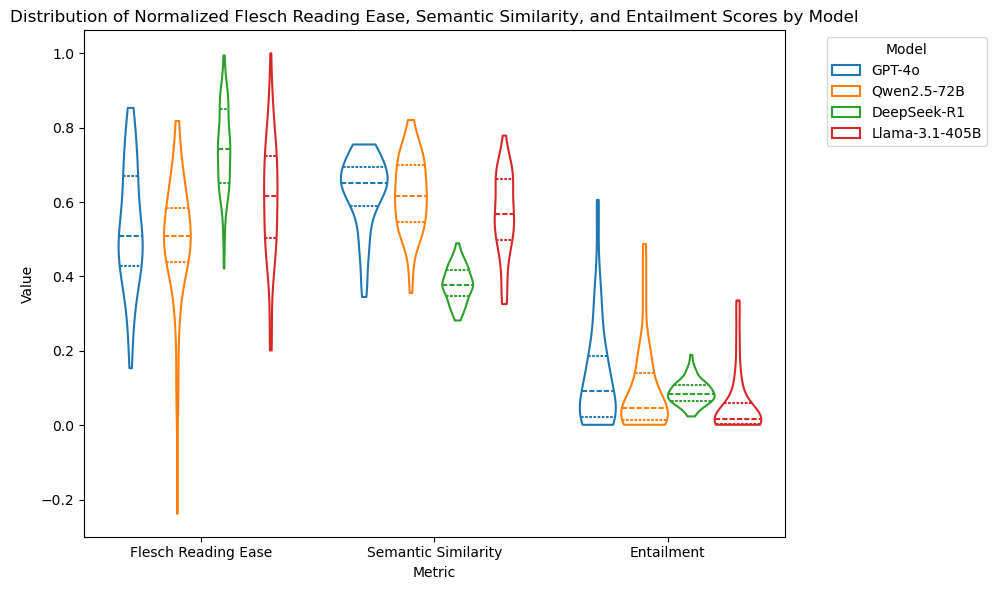

In [18]:
# 3. Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=melted, x='metric', y='value', hue='model', inner="quart", fill=False,
               cut=0)
plt.title('Distribution of Normalized Flesch Reading Ease, Semantic Similarity, and Entailment Scores by Model')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Final Plot

/var/folders/mv/5359mrfx7yq8dl6fs3p4gy000000gn/T/ipykernel_68905/3112259580.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


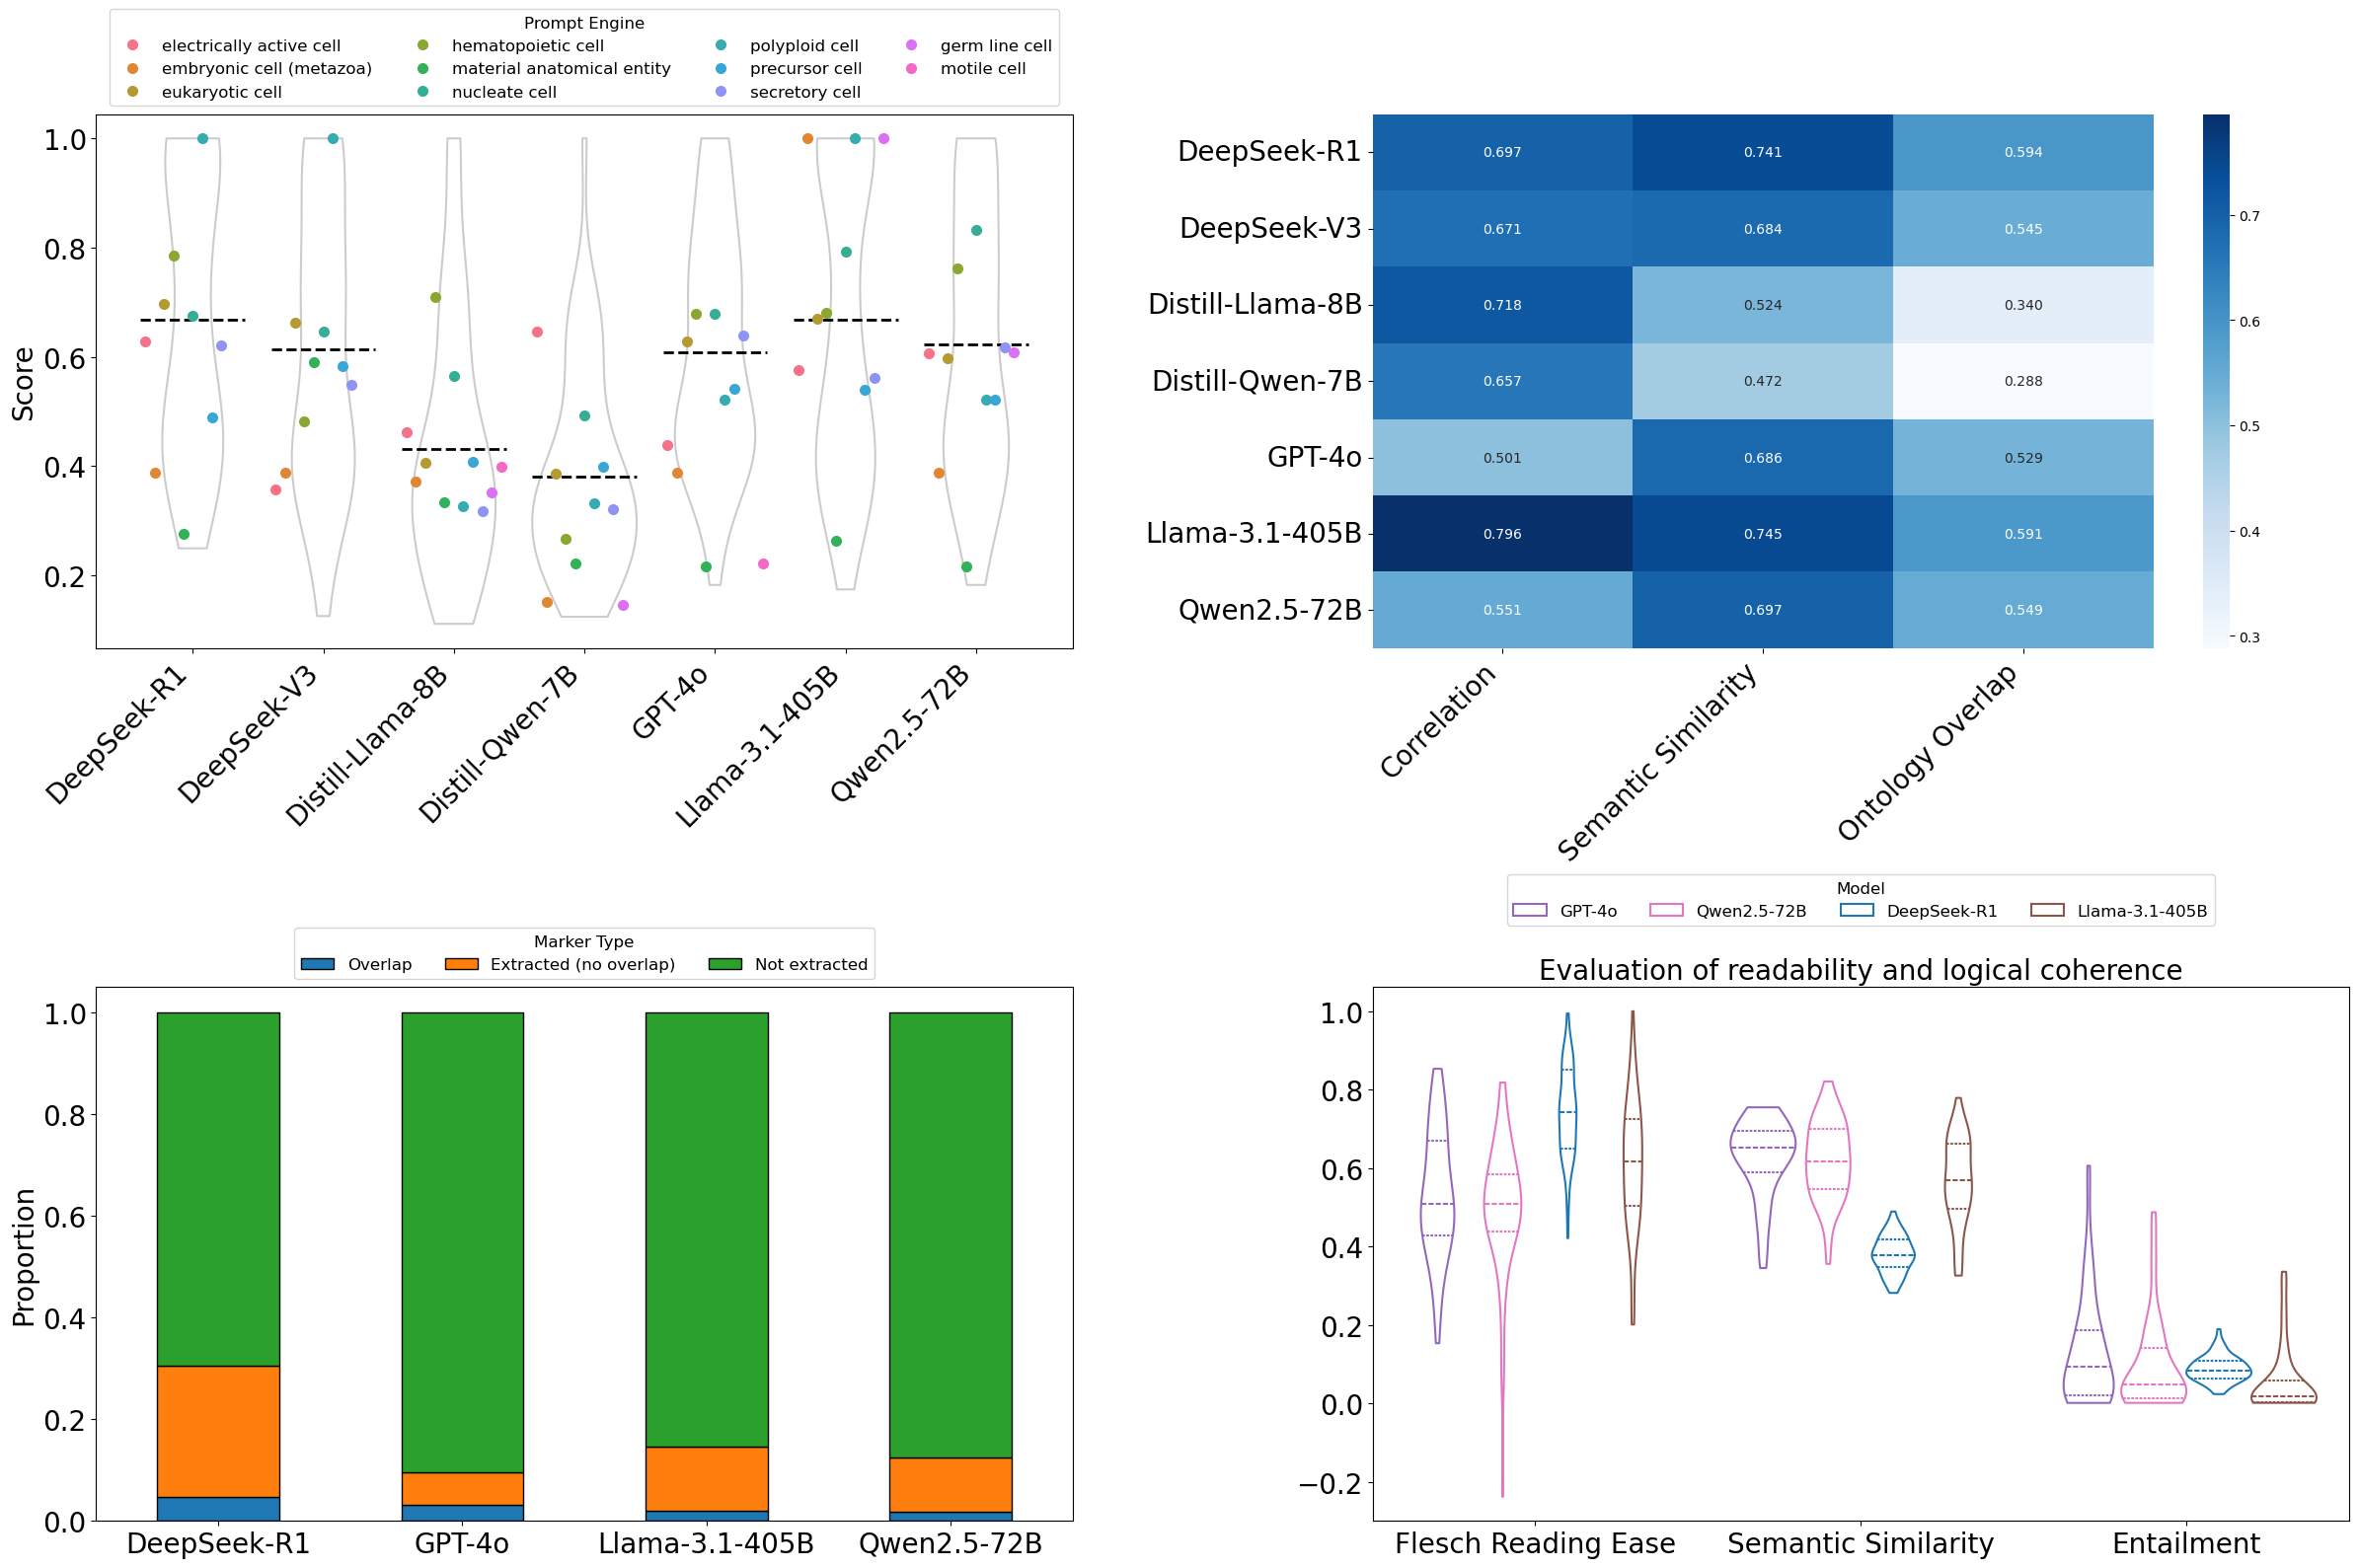

In [23]:
# Create 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 16))
fig.subplots_adjust(wspace=0.2,  # space between columns
                    hspace=0.6)  # space between rows

# Define a consistent palette for models (using models from acc_df as an example)
models = sorted(res['model'].unique())
palette = sns.color_palette("tab10", n_colors=len(models))
color_map = dict(zip(models, palette))

## Subplot 1: Violin & Strip Plot
ax1.tick_params(axis='both', which='major', labelsize=20)
# Define a consistent order for models (alphabetical order here)
model_order = sorted(res['model'].unique())
sns.violinplot(x='model', y='final_score', data=res, inner=None, color=".8", order=model_order, fill=False, cut=0, ax=ax1)
sns.stripplot(x='model', y='final_score', data=model_group_means, hue='group',
              dodge=True, jitter=True, size=8, order=model_order, ax=ax1)

# Compute the overall mean accuracy for each model and draw horizontal dashed lines (optional)
model_means = res.groupby('model')['final_score'].mean().reset_index()
for i, model in enumerate(model_order):
    mean_val = model_means.loc[model_means['model'] == model, 'final_score'].values[0]
    ax1.hlines(mean_val, i - 0.4, i + 0.4, colors='black', linestyles='--', lw=2)
ax1.set_ylabel('Score', fontsize=20)
ax1.set_xlabel("")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(title='Prompt Engine', bbox_to_anchor=(0.5, 1), loc='lower center', ncol=4, fontsize=12, title_fontsize=12)

## Subplot 2: Heatmap
ax2.tick_params(axis='both', which='major', labelsize=20)
sns.heatmap(
    df_avg, 
    annot=df_avg,         # Annotate with actual metric values
    fmt=".3f", 
    cmap="Blues",
    ax=ax2
)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylabel('')

## Subplot 3: Barplot with consistent colors
ax3.tick_params(axis='both', which='major', labelsize=20)
df_grouped.plot(kind='bar', stacked=True, edgecolor='black', ax=ax3)
#ax3 = proportions.plot(kind='bar', stacked=True, edgecolor='black')
ax3.set_ylabel('Proportion', fontsize=20)
ax3.set_xlabel('')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.legend(title='Marker Type', bbox_to_anchor=(0.5, 1), loc='lower center', ncol=5, fontsize=12, title_fontsize=12)

## Subplot 4: Regression lines with consistent colors
ax4.tick_params(axis='both', which='major', labelsize=20)
sns.violinplot(data=melted, x='metric', y='value', hue='model', inner="quart", fill=False,
               cut=0, ax=ax4, palette=color_map)
ax4.set_title('Evaluation of readability and logical coherence', fontsize=20)
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.legend(title="Model", bbox_to_anchor=(0.5, 1.1), loc='lower center', ncol=5, fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.savefig('/Users/linxy29/Documents/Files/other collaboration/benchmark/f2_annotation.pdf')
plt.show()